# Capstone 3: Making Predictions on Depletion of Five Natural Resources

## Production and Consumption: Synthetic Control

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.linear_model import Lasso

In [2]:
!pip install pycausalimpact

In [23]:
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

### 1. Oil

In [97]:
# Load data
path1 = r'C:\Users\yuvem\ds_oil_consumption_melt.xlsx'
xls = pd.ExcelFile(path1)
ds = pd.read_excel(xls)
ds

,Country,Year,Barrels_daily
0,Canada,1965,1108.116301
1,Mexico,1965,315.871088
2,US,1965,11512.436000
3,NaN,1965,NaN
4,Argentina,1965,455.904822
...,...,...,...
5595,Taiwan,2020,973.107164
5596,Thailand,2020,1271.199472
5597,Vietnam,2020,490.671699
5598,Other Asia Pacific,2020,471.636775


### Data Cleaning

In [98]:
# Check total NaN values
ds.isna().sum()

Country          392
Year               0
Barrels_daily    729
dtype: int64

In [99]:
# Drop NaN values
ds.dropna()
# Eliminate NaN from 'Country' column
ds_clean = ds[ds["Country"].notna()]
# Replace missing values in 'Barrels_daily' with mean
ds_clean["Barrels_daily"] = ds_clean["Barrels_daily"].fillna(ds_clean.Barrels_daily.mean())

<ipython-input-99-b1dbd69f3a55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_clean["Barrels_daily"] = ds_clean["Barrels_daily"].fillna(ds_clean.Barrels_daily.mean())


In [100]:
ds.Country.unique()

array(['Canada', 'Mexico', 'US', nan, 'Argentina', 'Brazil', 'Chile',
       'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela',
       'Central America', 'Other Caribbean', 'Other South America',
       'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands',
       'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'Ukraine', 'United Kingdom', 'Other Europe ', 'Total Europe ',
       'Azerbaijan', 'Belarus', 'Kazakhstan', 'Russian Federation',
       'Turkmenistan', 'USSR', 'Uzbekistan', 'Other CIS', 'Iran', 'Iraq',
       'Israel', 'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia',
       'United Arab Emirates', 'Other Middle East', 'Algeria', 'Egypt',
       'Morocco', 'South Africa', 'Eastern 

In [101]:
ds.dtypes

Country           object
Year               int64
Barrels_daily    float64
dtype: object

In [102]:
ds_clean.isna().sum()

Country          0
Year             0
Barrels_daily    0
dtype: int64

In [103]:
# Convert Year to datetime
ds_clean['Year'] = pd.to_datetime(ds_clean.Year, format='%Y')

<ipython-input-103-1365e2188a64>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_clean['Year'] = pd.to_datetime(ds_clean.Year, format='%Y')


In [104]:
# Find index for Venezuela
i = ds_clean[((ds_clean.Country == 'Venezuela'))].index
i

Int64Index([  11,  111,  211,  311,  411,  511,  611,  711,  811,  911, 1011,
            1111, 1211, 1311, 1411, 1511, 1611, 1711, 1811, 1911, 2011, 2111,
            2211, 2311, 2411, 2511, 2611, 2711, 2811, 2911, 3011, 3111, 3211,
            3311, 3411, 3511, 3611, 3711, 3811, 3911, 4011, 4111, 4211, 4311,
            4411, 4511, 4611, 4711, 4811, 4911, 5011, 5111, 5211, 5311, 5411,
            5511],
           dtype='int64')

In [105]:
# Create separate df for without Venezuela
other_countries = ds_clean.drop(i)
# Transform
other_countries = other_countries.set_index('Year').T
othercountries_subset = other_countries.drop('Country')

# Separate df for only Venezuela
venezuela = ds_clean[((ds_clean.Country == 'Venezuela'))]
# Transform
venezuela = venezuela.set_index('Year').T
venezuela_subset = venezuela.drop('Country')

In [106]:
venezuela_subset

Year,1965-01-01,1966-01-01,1967-01-01,1968-01-01,1969-01-01,1970-01-01,1971-01-01,1972-01-01,1973-01-01,1974-01-01,...,2011-01-01,2012-01-01,2013-01-01,2014-01-01,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01
Barrels_daily,183.879953,181.469395,185.728871,201.42559,200.370616,209.874364,212.341753,230.821601,257.25874,259.424603,...,720.639562,784.801612,834.859877,746.403925,696.901659,537.383707,492.826716,409.781167,295.88749,241.64205


In [107]:
# Combine the two datasets
ds_combine = othercountries_subset.append(venezuela_subset, ignore_index=True)
ds_combine

Year,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,1965-01-01,...,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
0,1108.116301,315.871088,11512.436,455.904822,305.673808,70.51694,81.432291,13.394795,74.43827,35.17133,...,147.975594,437.336774,377.538233,1332.368002,2560.202186,103.544796,973.107164,1271.199472,490.671699,471.636775
1,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,183.879953,...,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205,241.64205


In [108]:
# Transform
ds_combine_transform = ds_combine.T

In [109]:
ds_combine_transform[1]

Year
1965-01-01    183.879953
1965-01-01    183.879953
1965-01-01    183.879953
1965-01-01    183.879953
1965-01-01    183.879953
                 ...    
2020-01-01     241.64205
2020-01-01     241.64205
2020-01-01     241.64205
2020-01-01     241.64205
2020-01-01     241.64205
Name: 1, Length: 5152, dtype: object

In [116]:
# Remove duplicates 
ds_combine_transform = ds_combine_transform[~ds_combine_transform.index.duplicated(keep='first')]

In [117]:
ds_combine_transform

,0,1
Year,,
1965-01-01,1108.116301,183.879953
1966-01-01,1167.468795,181.469395
1967-01-01,1245.557068,185.728871
1968-01-01,1322.15735,201.42559
1969-01-01,1380.190329,200.370616
1970-01-01,1471.579753,209.874364
1971-01-01,1512.128247,212.341753
1972-01-01,1588.909235,230.821601
1973-01-01,1754.885644,257.25874


## Causal Impact

In [121]:
# Create pre and post periods
pre_period = ['1965-01-01','1985-01-01']
post_period = ['1986-01-01','2020-01-01']

In [122]:
pre_period

['1965-01-01', '1985-01-01']

D:\User\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\User\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2163.01            75705.21
Prediction (s.d.)         2101.91 (52.37)    73566.98 (1832.79)
95% CI                    [1998.65, 2203.92] [69952.78, 77137.19]

Absolute effect (s.d.)    61.09 (52.37)      2138.24 (1832.79)
95% CI                    [-40.91, 164.36]   [-1431.98, 5752.43]

Relative effect (s.d.)    2.91% (2.49%)      2.91% (2.49%)
95% CI                    [-1.95%, 7.82%]    [-1.95%, 7.82%]

Posterior tail-area probability p: 0.12
Posterior prob. of a causal effect: 87.81%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2163.01. In the absence of an
intervention, we would have expected an average response of 2101.91.
The 95% interval of this counterfactual prediction is [1998.65, 2203.92].
Subtracting this predictio

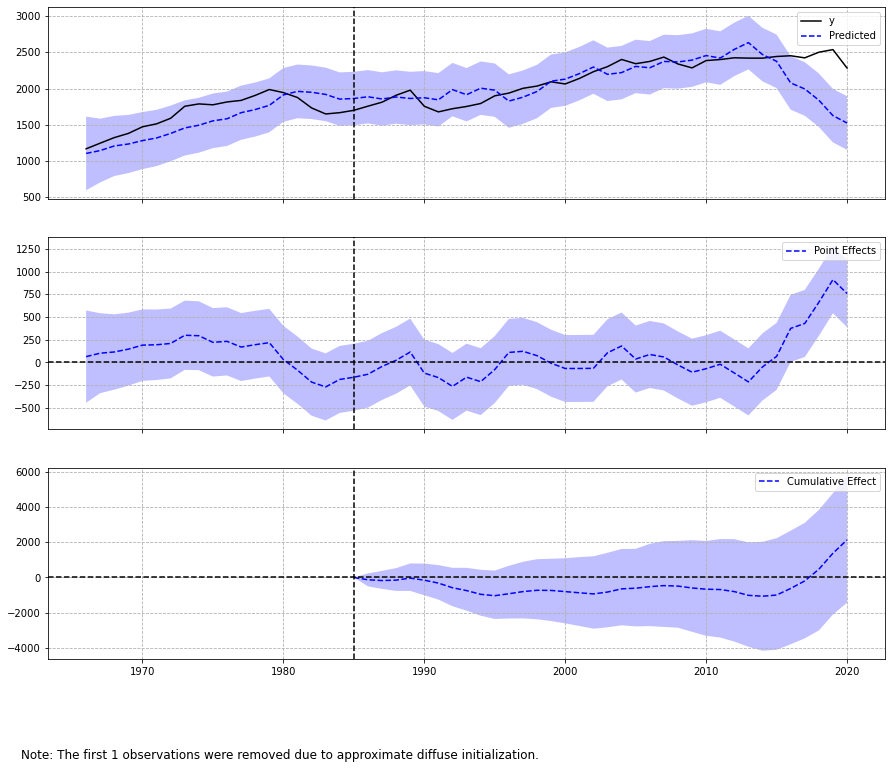

In [124]:
ci = CausalImpact(ds_combine_transform.astype(float), pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

## Lasso Regression

In [150]:
ds_pivot = ds_clean.pivot_table(index=['Country', 'Year'], values='Barrels_daily')
ds_pivot

Barrels_daily
Country        Year                     
Algeria        1965-01-01      26.716192
               1966-01-01      35.353233
               1967-01-01      33.285973
               1968-01-01      35.374426
               1969-01-01      37.714329
...                                  ...
Western Africa 2016-01-01     633.833068
               2017-01-01     696.812004
               2018-01-01     808.008446
               2019-01-01     816.357377
               2020-01-01     726.432937

[5208 rows x 1 columns]

In [151]:
ds_pivot = ds.pivot_table(index='Year', columns='Country', values='Barrels_daily')

In [152]:
ds_pivot.isnull().sum()

Country
Algeria            0
Argentina          0
Australia          0
Austria            0
Azerbaijan        20
                  ..
United Kingdom     0
Uzbekistan        20
Venezuela          0
Vietnam            0
Western Africa     0
Length: 93, dtype: int64

In [153]:
null_columns = ds_pivot[ds_pivot.columns[ds_pivot.isna().any()]]
null_columns.columns

Index(['Azerbaijan', 'Bangladesh', 'Belarus', 'Croatia', 'Estonia',
       'Kazakhstan', 'Latvia', 'Lithuania', 'North Macedonia', 'Other CIS',
       'Russian Federation', 'Slovenia', 'Turkmenistan', 'USSR', 'Ukraine',
       'Uzbekistan'],
      dtype='object', name='Country')

In [154]:
ds_pivot = ds_pivot.drop(columns='Azerbaijan')
ds_pivot = ds_pivot.drop(columns='Bangladesh')
ds_pivot = ds_pivot.drop(columns='Belarus')
ds_pivot = ds_pivot.drop(columns='Croatia')
ds_pivot = ds_pivot.drop(columns='Estonia')
ds_pivot = ds_pivot.drop(columns='Kazakhstan')
ds_pivot = ds_pivot.drop(columns='Latvia')
ds_pivot = ds_pivot.drop(columns='Lithuania')
ds_pivot = ds_pivot.drop(columns='North Macedonia')
ds_pivot = ds_pivot.drop(columns='Other CIS')
ds_pivot = ds_pivot.drop(columns='Russian Federation')
ds_pivot = ds_pivot.drop(columns='Slovenia')
ds_pivot = ds_pivot.drop(columns='Turkmenistan')
ds_pivot = ds_pivot.drop(columns='USSR')
ds_pivot = ds_pivot.drop(columns='Ukraine')
ds_pivot = ds_pivot.drop(columns='Uzbekistan')

In [155]:
ds_pivot.dropna(axis=1, how='all')

Country,Algeria,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Central America,Chile,...,Thailand,Total Europe,Trinidad & Tobago,Turkey,US,United Arab Emirates,United Kingdom,Venezuela,Vietnam,Western Africa
Year,,,,,,,,,,,,,,,,,,,,,
1965,26.716192,455.904822,343.871534,106.652849,312.112712,305.673808,71.220959,1108.116301,78.491296,70.516940,...,47.561397,8219.067934,35.171330,69.373863,11512.436000,1.525784,1466.077589,183.879953,31.347253,74.447750
1966,35.353233,471.145265,367.427507,118.205781,318.668110,334.602575,81.128658,1167.468795,79.329008,77.453144,...,55.992795,9037.460259,35.418008,82.812219,12084.373000,1.628466,1573.598685,181.469395,68.509536,80.229999
1967,33.285973,484.093001,401.463178,125.648575,350.395123,344.540164,101.827370,1245.557068,83.439596,81.568631,...,61.973425,9825.686232,36.954166,97.020521,12560.345000,1.752314,1696.268740,185.728871,100.338166,81.612307
1968,35.374426,493.491220,435.991175,144.321038,405.103388,412.432377,120.457158,1322.157350,84.877640,86.063510,...,81.130000,10775.430263,37.560230,116.565847,13392.866000,1.950681,1794.164536,201.425590,102.080276,81.389313
1969,37.714329,516.678254,450.960822,158.686932,468.287863,456.564904,148.471699,1380.190329,90.361137,92.454944,...,87.969644,12030.565864,39.486990,129.439507,14136.795000,2.173273,1930.183151,200.370616,123.713820,89.915851
1970,43.009918,473.100912,496.753507,175.707808,511.709370,512.724685,172.552877,1471.579753,93.457051,97.837721,...,102.808877,13323.154587,40.506249,136.220658,14697.186000,2.530832,2030.725507,209.874364,128.258016,98.774216
1971,48.878493,505.333808,523.101014,196.213233,525.207863,564.487699,189.468822,1512.128247,97.921517,108.043534,...,114.386575,13999.892651,41.858630,160.353781,15212.493000,2.985890,2036.777260,212.341753,108.502315,129.480936
1972,53.543497,501.607240,532.159372,211.859454,566.885410,648.893825,196.510656,1588.909235,106.334867,114.291311,...,142.747814,14952.103718,67.287186,181.113415,16366.984000,3.895519,2155.154317,230.821601,111.719328,138.277865
1973,58.849260,507.443178,569.900630,230.396247,597.895507,797.461233,207.978164,1754.885644,111.782780,109.558740,...,151.426247,16075.728601,68.266164,222.633973,17307.679000,6.062712,2228.135616,257.258740,109.934923,152.987508


In [160]:
# Standard Scaler
scaler = StandardScaler()

ds_pivot[['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela']] = scaler.fit_transform(ds_pivot[['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela']])

In [163]:
ds_americas = ds_pivot[['Canada', 'Mexico', 'US', 'Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Trinidad & Tobago', 'Venezuela']]
ds_americas

Country,Canada,Mexico,US,Argentina,Brazil,Chile,Colombia,Ecuador,Peru,Trinidad & Tobago,Venezuela
Year,,,,,,,,,,,
1965,-2.315242,-1.900450,-2.869639,-0.706597,-1.739949,-1.231193,-1.943043,-1.415854,-1.539169,-0.236426,-1.544077
1966,-2.154488,-1.871058,-2.590004,-0.502297,-1.697290,-1.168472,-1.776265,-1.408423,-1.117842,-0.214818,-1.557760
1967,-1.942988,-1.829552,-2.357290,-0.328731,-1.682636,-1.131257,-1.761420,-1.393667,-1.101757,-0.080257,-1.533582
1968,-1.735519,-1.780206,-1.950249,-0.202746,-1.582520,-1.090611,-1.601247,-1.356177,-1.105453,-0.027169,-1.444484
1969,-1.578338,-1.739351,-1.586524,0.108079,-1.517442,-1.032815,-1.653049,-1.343991,-1.140032,0.141607,-1.450472
1970,-1.330813,-1.686796,-1.312534,-0.476081,-1.434627,-0.984141,-1.416090,-1.310849,-1.047874,0.230890,-1.396527
1971,-1.220988,-1.641369,-1.060588,-0.043995,-1.358296,-0.891853,-1.356948,-1.280283,-1.048714,0.349352,-1.382522
1972,-1.013029,-1.545432,-0.496128,-0.093950,-1.233828,-0.835357,-1.128726,-1.270195,-1.336028,2.576780,-1.277626
1973,-0.563487,-1.475578,-0.036199,-0.015718,-1.014747,-0.878152,-1.185410,-1.234215,-1.009325,2.662534,-1.127563


In [164]:
# Define x and y variables
x = ds_americas.drop(columns='Venezuela', axis=1)
y = ds_americas['Venezuela']

In [165]:
x.shape

(56, 10)

In [166]:
y.shape

(56,)

In [174]:
# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(42, 10) (14, 10) (42,) (14,)


In [175]:
# Regularization
reg = LinearRegression().fit(x_train, y_train)
reg.score(x_test, y_test)

0.9654813909625388

In [176]:
reg.score(x_train, y_train)

0.9681331857919419

In [177]:
from sklearn import linear_model

lasso_reg = linear_model.Lasso(alpha=0.5, max_iter=100, tol=0.1)
lasso_model = lasso_reg.fit(x_train, y_train)
lasso_model

Lasso(alpha=0.5, max_iter=100, tol=0.1)

In [178]:
# Lasso Score
lasso_reg.score(x_test, y_test)

0.604386877048854

## Plotting Lasso with multiple lambdas

In [186]:
# Apply lasso with different lambdas and get r2 score for all models
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = x.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

In [187]:
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(x_train, y_train)

    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(x_train, y_train)
    test_r_squared[ind] = reg.score(x_test, y_test)

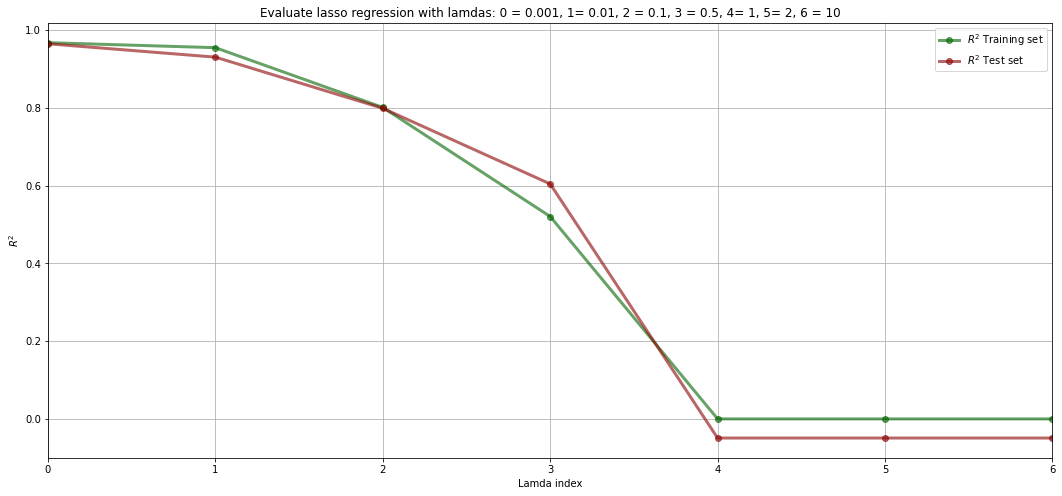

In [189]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkgreen", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()